# 2D Navier-Stokes Simulations

Showcasing a varity of intresting conditions

### Importing Python libraries

In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Set up volume

Create a volume of (200,200) cells, calculate some initial values

The fluid's density ρ (rho) is set to 1, the vicosity ν (nu) set to 0.0001

In [2]:
nx = 201
ny = 201
nt = 100
nit = 70
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 10, nx)
y = numpy.linspace(0, 10, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .0001
dt = 1e-9

u = numpy.zeros((ny, nx)) # X component of velocity
v = numpy.zeros((ny, nx)) # Y component of velocity
p = numpy.zeros((ny, nx)) # Pressure
b = numpy.zeros((ny, nx))

## Simulation

### Calculate that RHS term for the pressure

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

### Calculate the pressure

In [4]:
def pressure_poisson(p, dx, dy, b, pbound):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p = pbound(p)
        
    return p

### Calculate the velocity field

In [5]:
def flowsim(nt, u, v, dt, dx, dy, p, rho, nu, pbound, ubound):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, pbound)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        u,v=ubound(u,v)
        
        
    return u, v, p

## Flow over a Cavity

The fluid velocity is fixed to 0 on each wall except the top, where it is 1 moving across. This is like a flow over a cavity or box. The expected result is a vortex in the box

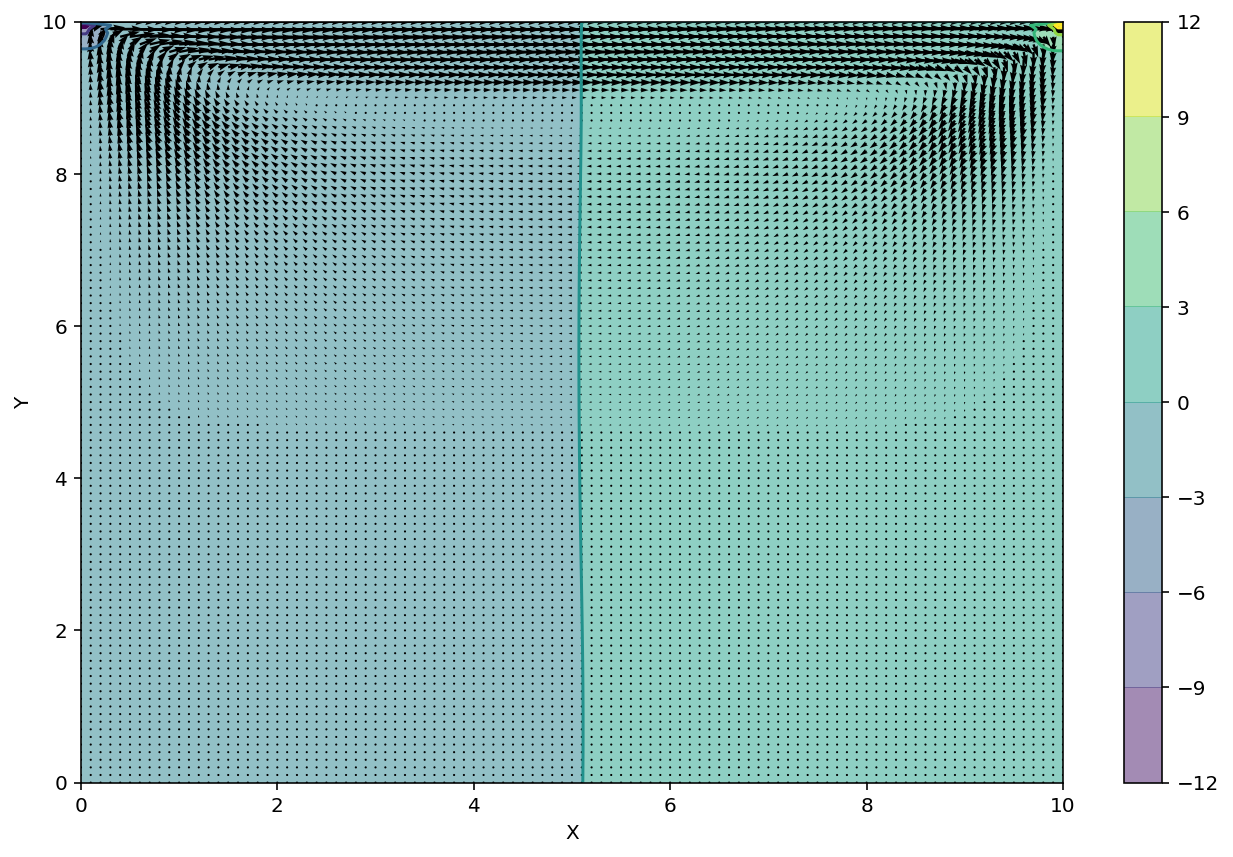

In [6]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
dt = 1e-4;
nt = 1000
nu = .1
def cavityubound(u,v):
    u[0, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0
    u[-1, :] = 1    #set velocity on cavity lid equal to 1
    
    v[0, :] = 0
    v[-1, :]=0
    v[:, 0] = 0
    v[:, -1] = 0
    return u,v

def cavitypbound(p):
    p[:, -1] = p[:, -2] ##dp/dy = 0 at x = 2
    p[0, :] = p[1, :]  ##dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]    ##dp/dx = 0 at x = 0
    p[-1, :] = 0        ##p = 0 at y = 2*
    return p

u, v, p = flowsim(nt, u, v, dt, dx, dy, p, rho, nu, cavitypbound, cavityubound)

fig = pyplot.figure(figsize=(11,7), dpi=144)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Flow over a circle

A fluid flowing from the left over a circle. This simulation is intresting because at the right speeds and viscosities vortices will form behind the circle

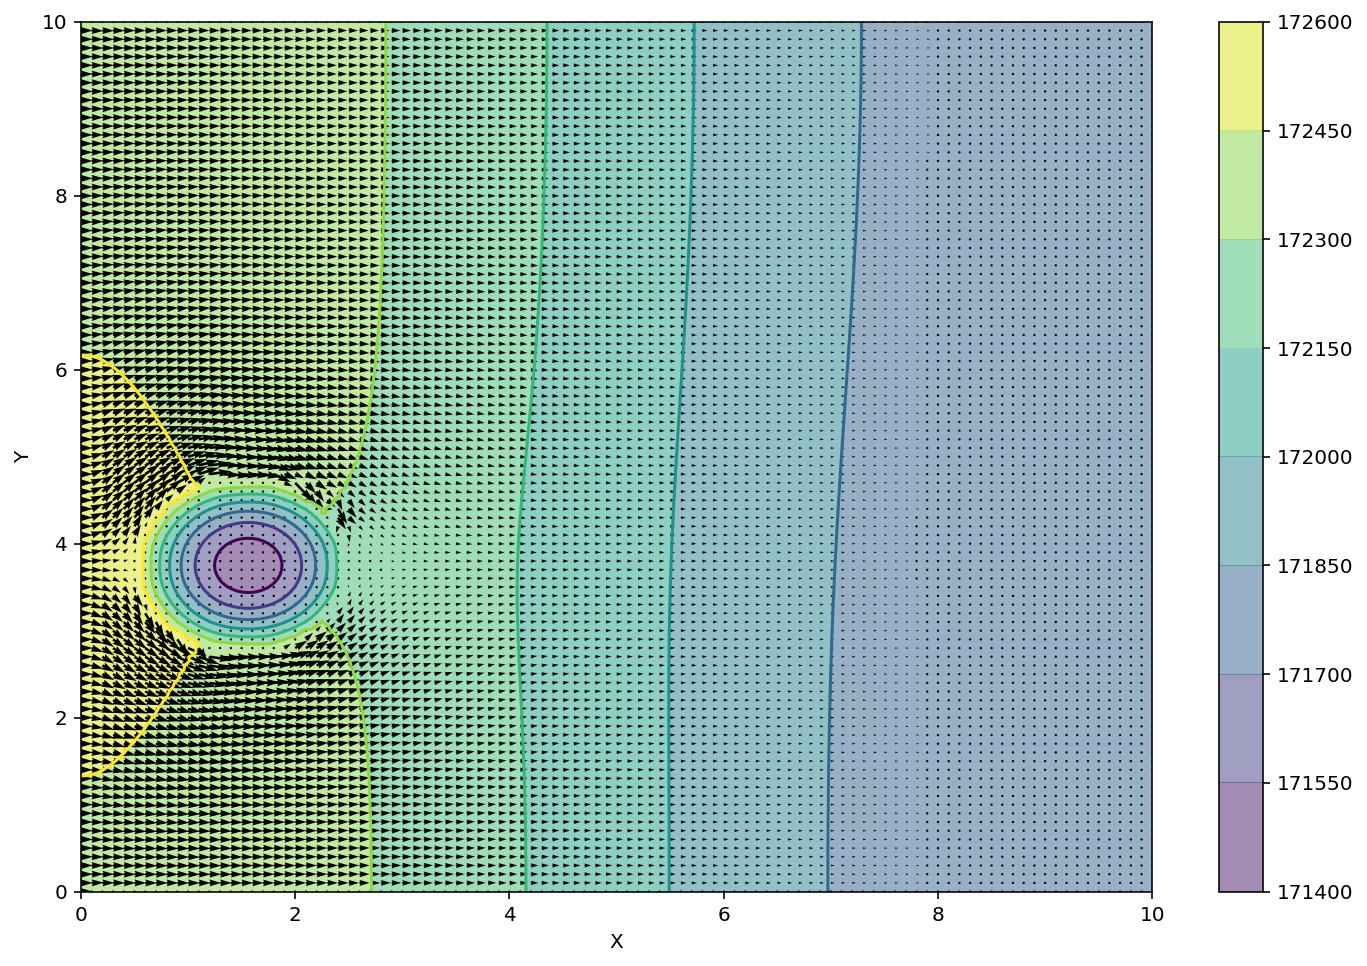

In [9]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 1000
dt = 1e-5
s = 2
nu = 0.001
def ballubound(u,v):
    u[0, :] = 0
    u[:, 0] = s
    u[:, -1] = 0
    u[-1, :] = 0
    
    v[0, :] = 0
    v[-1, :]=0
    v[:, 0] = 0
    v[:, -1] = 0
    for y in range(50,100):
        for x in range(0,100):
            if ((x-30)**2 + (y-75)**2) < 20**2:
                u[y,x] = 0
                v[y,x] = 0

    #u[:30,:30] = 0
    #v[:30,:30] = 0
    return u,v

def ballpbound(p):
    p[:, -1] = p[:, -2] ##dp/dy = 0 at x = 2
    p[0, :] = p[1, :]  ##dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]    ##dp/dx = 0 at x = 0
    p[-1, :] = p[-2, :]        ##p = 0 at y = 2
    #p[40:50,10:20] = 0
    return p

u, v, p = flowsim(nt, u, v, dt, dx, dy, p, rho, nu, ballpbound, ballubound)

fig = pyplot.figure(figsize=(12,8), dpi=144)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
#pyplot.quiver(X, Y, u, v) 
pyplot.xlabel('X')
pyplot.ylabel('Y')

This simulation takes longer, but exhibits the vortices

In [12]:
nt = 100000
dt = 1e-9
s = 500

u, v, p = flowsim(nt, u, v, dt, dx, dy, p, rho, nu, ballpbound, ballubound)

fig = pyplot.figure(figsize=(12,8), dpi=144)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()

# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
#pyplot.quiver(X, Y, u, v) 
pyplot.xlabel('X')
pyplot.ylabel('Y')

KeyboardInterrupt: 